In [3]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [4]:
paths = []
labels = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset is Loaded')

Dataset is Loaded


In [5]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

speech label
0  /kaggle/input/toronto-emotional-speech-set-tes...  fear
1  /kaggle/input/toronto-emotional-speech-set-tes...  fear
2  /kaggle/input/toronto-emotional-speech-set-tes...  fear
3  /kaggle/input/toronto-emotional-speech-set-tes...  fear
4  /kaggle/input/toronto-emotional-speech-set-tes...  fear

In [6]:
df['label'].value_counts()


label
fear       400
angry      400
disgust    400
neutral    400
sad        400
ps         400
happy      400
Name: count, dtype: int64

In [7]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

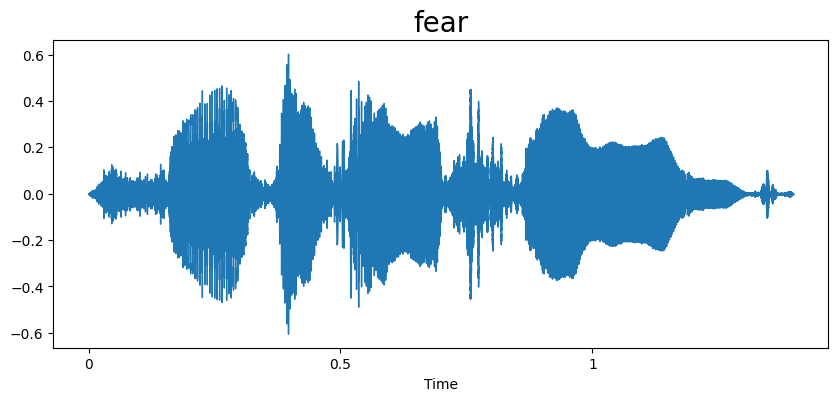

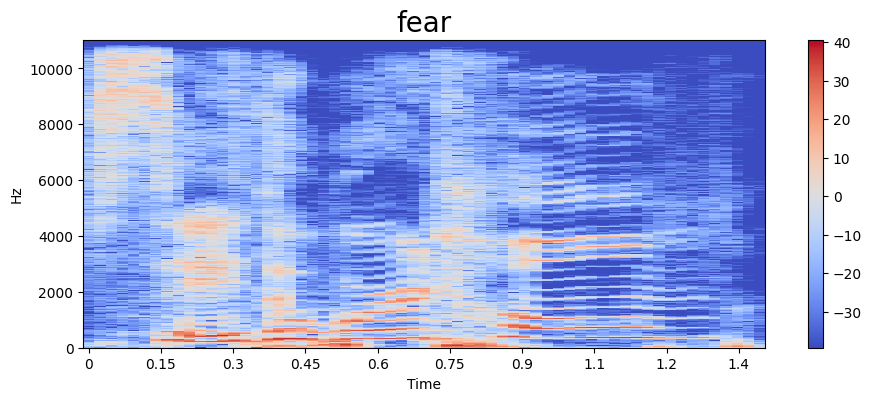

In [8]:
emotion = 'fear'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)


## Feature 


In [9]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [10]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [11]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))


In [12]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(2800, 40)

In [13]:
X = np.expand_dims(X, -1)
X.shape

(2800, 40, 1)

In [14]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

In [15]:
y = y.toarray()

In [16]:
y.shape


(2800, 7)

In [17]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

2024-07-16 15:04:10.126599: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 15:04:10.126707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 15:04:10.259360: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,799 (1.17 MB)

 Trainable params: 305,799 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model (assuming you've already built your model)

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    '/kaggle/working/best_model.keras',       # Path where the model will be saved
    monitor='val_accuracy',# Metric to monitor
    save_best_only=True,   # Save only the best model
    mode='max',            # We want to maximize the monitored metric
    verbose=1              # Verbosity mode
)

# Train the model with the checkpoint callback
history = model.fit(
    X, 
    y, 
    validation_split=0.2, 
    epochs=50, 
    batch_size=64, 
    callbacks=[checkpoint]  # Include the checkpoint callback in the training
)
#best_model = tf.keras.models.load_model('best_model.h5')


Epoch 1/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.0833e-06
Epoch 1: val_accuracy improved from -inf to 0.49643, saving model to /kaggle/working/best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 3.0674e-06 - val_accuracy: 0.4964 - val_loss: 6.8094
Epoch 2/50
32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.4991e-06
Epoch 2: val_accuracy did not improve from 0.49643
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.0639e-06 - val_accuracy: 0.4911 - val_loss: 6.8431
Epoch 3/50
30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2647e-06
Epoch 3: val_accuracy did not improve from 0.49643
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 3.9863e-06 - val_accuracy: 0.4875 - val_loss: 6.9196
Epoch 4/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9317e-06
Epoch 4: val_accuracy did not improve from 0.49643
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/s

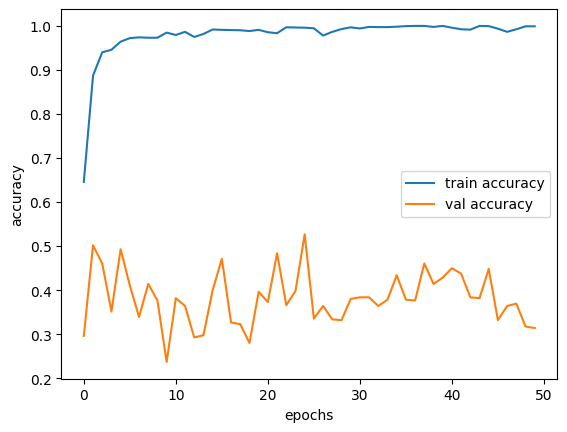

In [19]:
epochs = list(range(50))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

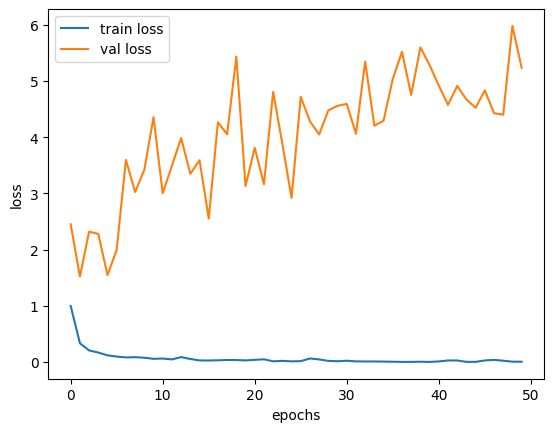

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()